<a href="https://colab.research.google.com/github/qaixerabbas/Tomato-Plant-Leaf-Disease-Detection/blob/master/Tomato_Plant_Leaf_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%cd /content/drive/'My Drive'/tomato

/content/drive/My Drive/tomato


In [0]:
#%env CUDA_VISIBLE_DEVICES=2

import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.optim import lr_scheduler
import copy
import shutil  
import re  

In [0]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [0]:
# Load the Data

# Set train and valid directory paths

dataset = './leaf_data/'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'val')

# Batch size
bs = 32

# Number of classes
num_classes = len(os.listdir(valid_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'val': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['val'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['val'], batch_size=bs, shuffle=True)

5
{0: 'bacterial_spot', 1: 'early_bright', 2: 'healthy', 3: 'late_bright', 4: 'target_spot'}


In [0]:
train_data_size, valid_data_size

(1750, 750)

In [0]:
# Load pretrained ResNet18 Model
alexnet = models.alexnet(pretrained=True)
alexnet = alexnet.to('cuda:0')

In [0]:
# num_ftrs = model_conv.classifier[6].in_features
# model_conv.classifier[6].out_features = Output_features

# for param in model_conv.classifier[6].parameters():
# param.requires_grad = True

# if use_gpu:
# model_conv = model_conv.cuda()

# criterion = nn.CrossEntropyLoss()

In [0]:
# Freeze model parameters
for param in alexnet.parameters():
    param.requires_grad = False

In [0]:
num_ftrs = alexnet.classifier[6].in_features

In [0]:
for param in alexnet.classifier[6].parameters():
  param.requires_grad = True

alexnet = alexnet.to('cuda:0')

In [0]:
# # # Change the final layer of ResNet18 Model for Transfer Learning
# # fc_inputs = resnet18.fc.in_features
# alexnet.fc = nn.Sequential(
#     nn.Linear(4096, 256),
#     nn.ReLU(),
#     nn.Dropout(0.4),
#     nn.Linear(256, num_classes), # Since 5 classes
#     nn.LogSoftmax(dim=1) # For using NLLLoss()
# )

# # Convert model to be used on GPU
# alexnet = alexnet.to('cuda:0')

In [0]:
# Define Optimizer and Loss Function
loss_func = nn.CrossEntropyLoss()
# optimizer = optim.Adam(resnet18.parameters())

In [0]:
optimizer = torch.optim.SGD(filter(lambda x: x.requires_grad, alexnet.parameters()), lr=0.001, momentum=0.9)

In [0]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history
    

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train the model
num_epochs = 30
trained_model, history = train_and_validate(alexnet, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

Epoch: 1/30
Epoch : 000, Training: Loss: 2.2447, Accuracy: 53.1429%, 
		Validation : Loss : 0.5361, Accuracy: 78.8000%, Time: 1479.7506s
Epoch: 2/30
Epoch : 001, Training: Loss: 0.6260, Accuracy: 76.4571%, 
		Validation : Loss : 0.4399, Accuracy: 83.6000%, Time: 17.6930s
Epoch: 3/30
Epoch : 002, Training: Loss: 0.6751, Accuracy: 74.2857%, 
		Validation : Loss : 0.4310, Accuracy: 83.4667%, Time: 17.1649s
Epoch: 4/30
Epoch : 003, Training: Loss: 0.5117, Accuracy: 80.8000%, 
		Validation : Loss : 0.4684, Accuracy: 83.3333%, Time: 17.3465s
Epoch: 5/30
Epoch : 004, Training: Loss: 0.4841, Accuracy: 81.1429%, 
		Validation : Loss : 0.3399, Accuracy: 87.2000%, Time: 17.5003s
Epoch: 6/30
Epoch : 005, Training: Loss: 0.4617, Accuracy: 82.3429%, 
		Validation : Loss : 0.4250, Accuracy: 83.3333%, Time: 17.3375s
Epoch: 7/30
Epoch : 006, Training: Loss: 0.4793, Accuracy: 81.9429%, 
		Validation : Loss : 0.3894, Accuracy: 85.2000%, Time: 17.1163s
Epoch: 8/30
Epoch : 007, Training: Loss: 0.4470, Accu

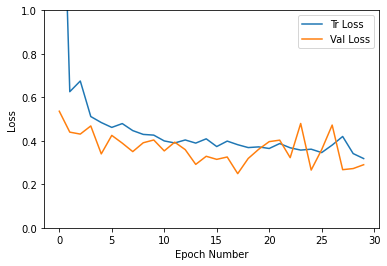

In [0]:
import numpy as np
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()


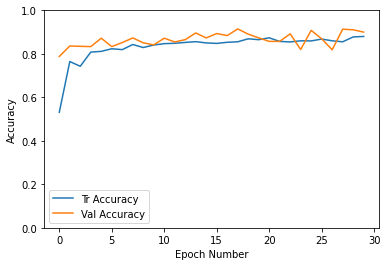

In [0]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [0]:
nb_classes = 5

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(valid_data_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = alexnet(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1


In [0]:
print(confusion_matrix)

tensor([[141.,   3.,   0.,   2.,   4.],
        [ 19., 105.,   1.,  14.,  11.],
        [  1.,   0., 143.,   0.,   6.],
        [  7.,   5.,   0., 136.,   2.],
        [  2.,   1.,   1.,   1., 145.]])


In [0]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([0.9400, 0.7000, 0.9533, 0.9067, 0.9667])
